## About the CIFAR-10 dataset
CIFAR is an acronym that stands for the Canadian Institute For Advanced Research and the ```CIFAR-10``` dataset was developed along with the ```CIFAR-100``` dataset by researchers at the CIFAR institute.
The ```CIFAR-10``` dataset consists of a training set of 50,000 examples and a test set of 10,000 examples. Each example is a 32x32 pixel color image, associated with a label from 10 classes, such as frogs, birds, cats, ships, etc. 

In [9]:
# example of loading the CIFAR10 dataset
from matplotlib import pyplot
from keras.datasets import cifar10 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout)
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

In [10]:
def plotLossAccGraph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    # ax1.set_ylim(bottom=0.0, top=0.6)
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    # ax2.set_ylim(bottom=0.85, top=1.0)
    ax2.legend()

    plt.show()

### Loading the dataset
We first call ```load_data()``` from ```tensorflow.keras.datasets.cifar10``` which returns 2 tuples for the training and test images, as well as the labels respectively.

In [11]:
# Step 1: load train and test dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('Before preprocessing:')
print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))

Before preprocessing:
 - X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 1)
 - X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 1)


### Preprocessing the data
1. Shuffle the train and test sets to get rid of any kind of implicit sorting.
2. Create cross validation and test data sets.
3. Set aside a copy of the test set ```X_test/y_test``` before applying any pre-processing steps for visualization.
> Cross validation is where the model is trained on the training data set & its performance evaluated on a cross-validation data on each epoch of training.

I will randomly split the 10,000 samples from ```X_test/y_test``` into 8,000 samples for the cross validation set ```X_val/y_val```, and 2,000 samples for the test set ```X_test/y_test```.

In [12]:
# Step 2: split the X_test/y_test dataset into cross-val & test datasets
# Split X_test/y_test into cross-validation & test datasets.
# We have 10,000 samples in X_test/y_test - we will assign 8,000 to X_val/y_val & the
# remaining 2,000 to X_test/y_test (test dataset) AFTER randomly sorting the dataset

# randomly sort X_test/y_test
indexes = np.arange(X_test.shape[0])
for _ in range(5): 
  indexes = np.random.permutation(indexes)  # shuffle 5 times!
X_test = X_test[indexes]
y_test = y_test[indexes]

# 'split' into cross-val & test sets (use 8000 records in cross-val set)    
val_count = 8000
X_val = X_test[:val_count]
y_val = y_test[:val_count]
X_test = X_test[val_count:]
y_test = y_test[val_count:]

# keep an non pre-processed copy of X_test/y_test for visualization
test_images, test_labels = X_test.copy(), y_test.copy()

Scale the images ```X_train, X_val & X_test``` to floats between 0 and 1. Models train faster on data on uniform and small scales.

In [13]:
# Step 3: scale pixels

# convert from integers to floats
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [14]:
# display a random selection of images & corresponding labels
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
 
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    CIFAR10_LABELS = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap="Greys")

                # show the actual labels in the cell title
                title = ax[r, c].set_title("%s" % CIFAR10_LABELS[sample_labels[image_index][0]])
                
                    
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

### Viewing a sample of the dataset
Here is a random sample of 50 images from ```test_images``` and ```test_labels```, presented in a 5x10 grid.

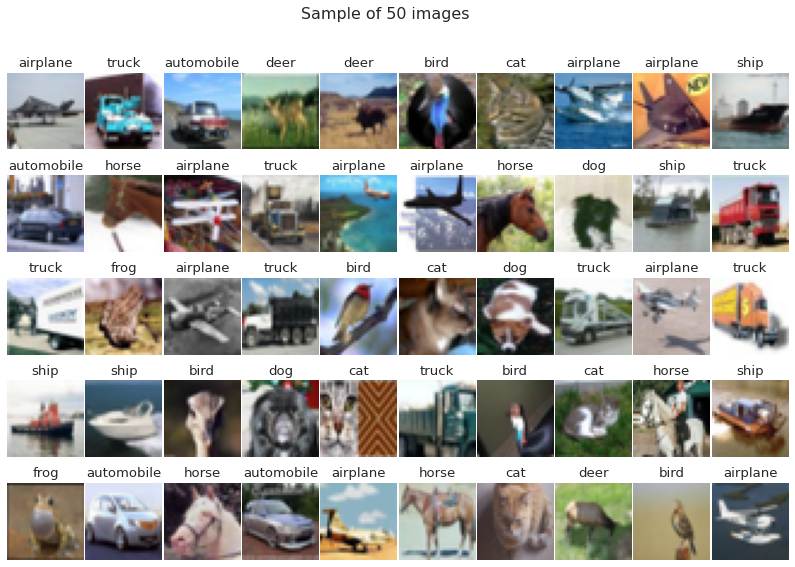

In [15]:
# Viewing a sample of the dataset
sample_size = 50
rand_indexes = np.random.randint(0, len(X_test), sample_size)
sample_images = test_images[rand_indexes]
sample_labels = test_labels[rand_indexes]
display_sample(sample_images, sample_labels, 
               plot_title='Sample of %d images' % sample_size)

### Building a baseline model
Here I built a simple baseline model consisting of a single convolutional layer and a single dense layer of 100 units, with a ```softmax``` activation function. I did not perform one-hot encoding on my labels ```y_train/y_test``` and left them as integers to save time in memory as well as computation. As a result, I used ```sparse_categorical_crossentropy``` as my loss function because it simply uses a single integer for a class, rather than a whole vector.

In [50]:
# define cnn model (baseline)
def define_model():
    model = tf.keras.Sequential([
        # first convolutional layer
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(pool_size=(2,2)),

        # fully connected classifier
        Flatten(), 
        Dense(100, activation='relu'), 
        Dense(10, activation='softmax')
    ])
    # compile model
    opt = Adam(learning_rate=0.0001, decay=1e-6)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Each of these callbacks gets called by TensorFlow after every epoch.  
The ```EarlyStopping``` callback stops training if the validation accuracy does not improve anymore. With patience, we set the number of epochs to wait before stopping when TensorFlow sees no progress.  
The ```ReduceLROnPlateau``` callback automatically reduces the learning rate if it doesn’t see any improvement.

In [51]:
def create_callbacks():
  early_stopping = EarlyStopping(patience=10, monitor='val_loss', verbose=1)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=0.00001,
                                patience=5, mode='min',
                                verbose=1)

### Training the model
My model training process is as follows:
1. Train the model with the cross-validation technique where the model is trained on the entire training dataset ```(X_train/y_train)``` and its performance cross-validated on the cross-val ```(X_val/y_val)``` data per epoch.
2. Next, plot the training and cross-validation losses vs epochs and training & cross-validation accuracies vs epochs.
3. Finally, I evaluated the model’s performance on the test data ```(X_test/y_test)``` which gives an independent evaluation of my model’s performance since the model has never seen the 'holdout' test data.

In [52]:
# Training our model (baseline)

# train on X_train/y_train & cross-validate on X_val/y_val
model = define_model()
model.summary()
history = model.fit(X_train, y_train, epochs=25, batch_size=256, validation_data=(X_val, y_val), verbose=2, callbacks=create_callbacks())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 100)               720100    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 722,006
Trainable params: 722,006
Non-trainable params: 0
__________________________________________________

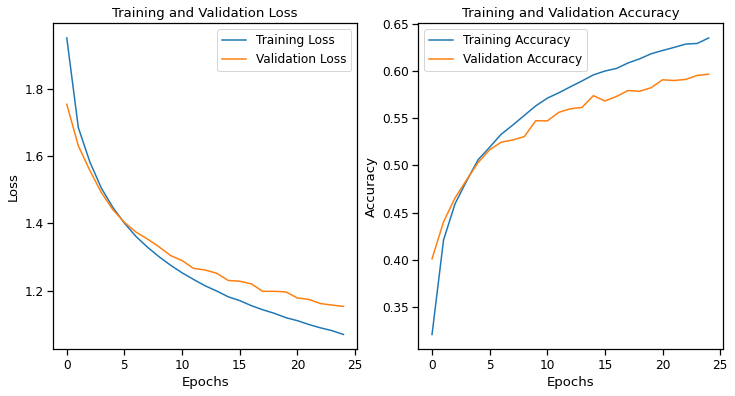

In [53]:
plotLossAccGraph(history)

In [54]:
# Evaluating performance on train dataset
loss, acc = model.evaluate(X_train, y_train)
print('  - Train data: loss %.3f - acc %.3f' % (loss, acc))

1563/1563 [==============================] - 4s 2ms/step - loss: 1.0584 - accuracy: 0.6374
  - Train data: loss 1.058 - acc 0.637


In [55]:
# Evaluating performance on cross-validation dataset
loss, acc = model.evaluate(X_val, y_val)
print('  - Cross-val data: loss %.3f - acc %.3f' % (loss, acc))

250/250 [==============================] - 1s 2ms/step - loss: 1.1527 - accuracy: 0.5964
  - Cross-val data: loss 1.153 - acc 0.596


In [56]:
# Evaluating performance on test dataset
loss, acc = model.evaluate(X_test, y_test)
print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

63/63 [==============================] - 0s 2ms/step - loss: 1.1052 - accuracy: 0.6195
  - Test data: loss 1.105 - acc 0.619


### Observations and conclusions from first training
The model achieves:     
* Training accuracy - 63.7%
* Cross-validation accuracy - 59.6%
* Test accuracy - 61.9%

Validation loss appears to keep dropping even after the 25th epoch, which suggests that more epochs are needed.  
The cross-val and test accuracy were also both lower than training accuracy, which suggests that the model is over-fitting.

  
<br>

| Model | Training acc | Cross-val acc | Test acc |
| :----: | :----: | :----:| :----: |
| Baseline model | 63.7% | 59.6% | 61.9% |

### Model improvement
The first baseline model was too complex and was over-fitting the training data. Here I will try to reduce over-fitting through weight regularization and dropout regularization.  


### What is dropout regularization?
> Dropout works by randomly dropping out (setting to zero) a number of output features (or nodes) of a layer during training. 

The dropout rate controls the fraction of the nodes that are dropped out.  
I added in dropout for model 2.

In [57]:
# define cnn model (with dropout)
def define_model2():
    model = tf.keras.Sequential([
        # first convolutional layer
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.20),

        # second convolutional layer
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.20),

        # third convolutional layer
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.20),

        # fully connected classifier
        Flatten(), 
        Dense(100, activation='relu'),
        Dropout(0.20),
        Dense(10, activation='softmax')
    ])
    # compile model
    opt = Adam(learning_rate=0.0001, decay=1e-6)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [58]:
# Training our second model

# train on X_train/y_train & cross-validate on X_val/y_val
model2 = define_model2()
model2.summary()
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_val, y_val), verbose=2, callbacks=create_callbacks())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

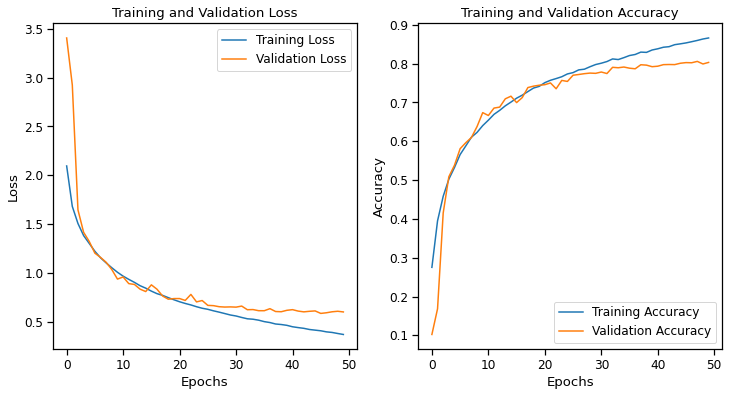

In [59]:
plotLossAccGraph(history2)

In [60]:
# Evaluating performance on train dataset
loss, acc = model2.evaluate(X_train, y_train)
print('  - Train data: loss %.3f - acc %.3f' % (loss, acc))

1563/1563 [==============================] - 5s 3ms/step - loss: 0.2029 - accuracy: 0.9339
  - Train data: loss 0.203 - acc 0.934


In [61]:
# Evaluating performance on cross-validation dataset
loss, acc = model2.evaluate(X_val, y_val)
print('  - Cross-val data: loss %.3f - acc %.3f' % (loss, acc))

250/250 [==============================] - 1s 3ms/step - loss: 0.6020 - accuracy: 0.8031
  - Cross-val data: loss 0.602 - acc 0.803


In [62]:
# Evaluating performance on test dataset
loss, acc = model2.evaluate(X_test, y_test)
print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

63/63 [==============================] - 0s 3ms/step - loss: 0.5785 - accuracy: 0.8185
  - Test data: loss 0.578 - acc 0.818


### Observations and conclusions from second model
The model achieves:     
* Training accuracy - 93.3%
* Cross-validation accuracy - 80.3%
* Test accuracy - 81.8%

<br>

| Model | Training acc | Cross-val acc | Test acc |
| :----: | :----: | :----:| :----: |
| Baseline model | 63.7% | 59.6% | 61.9% |
| Dropout | 93.3% | 80.3% | 81.8% |

<br>
After applying dropout, over-fitting has been reduced. Training accuracy rose from 63.7% to 93.3%, cross-val accuracy rose from 59.6% to 80.3% and test accuracy rose by 19.9% to 81.8%.

### What is weight regularization?
> In machine learning, regularization penalizes the coefficients while in deep learning, it actually penalizes the weight matrices of the nodes.

```L2 regularization``` works by adding a term to the error function used by the training algorithm, which penalizes large weight values.  
Here I added ```l2 regularization``` to model 3 in addition to existing dropout.

In [63]:
# define cnn model 3 with dropout AND regularization
def define_model3():
  l2 = regularizers.l2(0.01)
  model = tf.keras.Sequential([
      # first convolutional layer
      Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2, input_shape=(32, 32, 3)),
      BatchNormalization(),
      Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(0.20),

      # second convolutional layer
      Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
      BatchNormalization(),
      Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(0.20),

      # third convolutional layer
      Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
      BatchNormalization(),
      Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
      BatchNormalization(),    
      MaxPooling2D(pool_size=(2,2)),
      Dropout(0.20),

      # fully connected classifier
      Flatten(), 
      Dense(100, activation='relu', kernel_regularizer=l2),
      Dropout(0.20),
      Dense(10, activation='softmax')
  ])
  # compile model
  opt = Adam(learning_rate=0.0001, decay=1e-6)
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [64]:
# Training our third model

# train on X_train/y_train & cross-validate on X_val/y_val
model3 = define_model3()
model3.summary()
history3 = model3.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_val, y_val), verbose=2, callbacks=create_callbacks())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

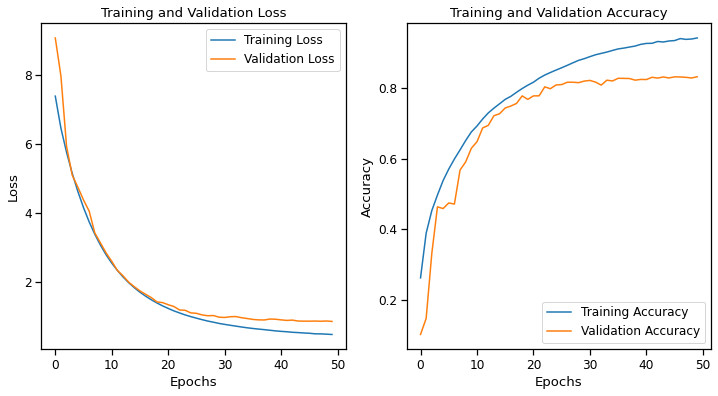

In [65]:
plotLossAccGraph(history3)

In [66]:
# Evaluating performance on train dataset
loss, acc = model3.evaluate(X_train, y_train)
print('  - Train data: loss %.3f - acc %.3f' % (loss, acc))

1563/1563 [==============================] - 5s 3ms/step - loss: 0.3761 - accuracy: 0.9860
  - Train data: loss 0.376 - acc 0.986


In [67]:
# Evaluating performance on cross-validation dataset
loss, acc = model3.evaluate(X_val, y_val)
print('  - Cross-val data: loss %.3f - acc %.3f' % (loss, acc))

250/250 [==============================] - 1s 3ms/step - loss: 0.8691 - accuracy: 0.8315
  - Cross-val data: loss 0.869 - acc 0.831


In [68]:
# Evaluating performance on test dataset
loss, acc = model3.evaluate(X_test, y_test)
print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

63/63 [==============================] - 0s 4ms/step - loss: 0.8728 - accuracy: 0.8330
  - Test data: loss 0.873 - acc 0.833


### Observations and conclusions from third model
The model achieves:     
* Training accuracy - 98.6%
* Cross-validation accuracy - 83.1%
* Test accuracy - 83.3%

<br>

| Model | Training acc | Cross-val acc | Test acc |
| :----: | :----: | :----:| :----: |
| Baseline model | 63.7% | 59.6% | 61.9% |
| Dropout | 93.3% | 80.3% | 81.8% |
| L2 regularization & Dropout | 98.6% | 83.1% | 83.3% |

<br>

After applying ```l2 regularization```, over-fitting has been further reduced. Training accuracy rose from 93.3% to 98.6%, cross-val accuracy rose from 80.3% to 83.1% and test accuracy rose by 1.5% to 83.3%.

For model 4, I decided to increment the dropout after each layer to see if it would improve the accuracy.

In [35]:
# define cnn model 4 with INCREASING dropout AND regularization
def define_model4():
  l2 = regularizers.l2(0.0001)
  model = tf.keras.Sequential([
      # first convolutional layer
      Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', activation='relu', padding='same', kernel_regularizer=l2, input_shape=(32, 32, 3)),
      BatchNormalization(),
      Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', activation='relu', padding='same', kernel_regularizer=l2),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(0.20),

      # second convolutional layer
      Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu', padding='same', kernel_regularizer=l2),
      BatchNormalization(),
      Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu', padding='same', kernel_regularizer=l2),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(0.30),

      # third convolutional layer
      Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu', padding='same', kernel_regularizer=l2),
      BatchNormalization(),
      Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu', padding='same', kernel_regularizer=l2),
      BatchNormalization(),    
      MaxPooling2D(pool_size=(2,2)),
      Dropout(0.40),

      # fully connected classifier
      Flatten(), 
      Dense(1024, activation='relu', kernel_regularizer=l2),
      Dropout(0.50),
      Dense(10, activation='softmax')
  ])
  # compile model
  opt = Adam(learning_rate=0.001)
  tf.keras.backend.clear_session()
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [36]:
# Training our fourth model

# train on X_train/y_train & cross-validate on X_val/y_val
model4 = define_model4()
model4.summary()
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_val, y_val), verbose=2, callbacks=create_callbacks())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

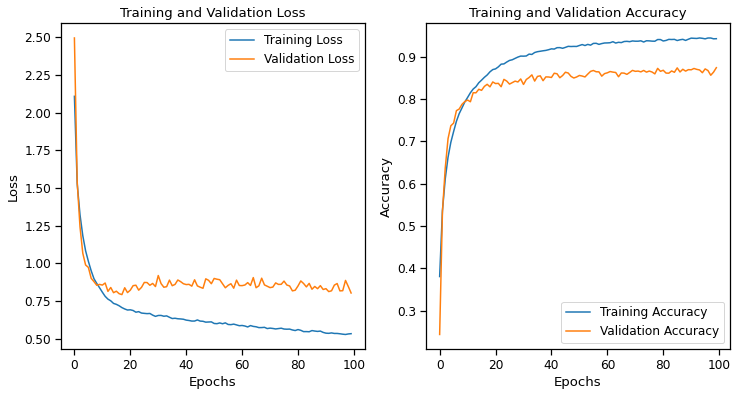

In [37]:
plotLossAccGraph(history4)

In [69]:
# Evaluating performance on train dataset
loss, acc = model4.evaluate(X_train, y_train)
print('  - Train data: loss %.3f - acc %.3f' % (loss, acc))

1563/1563 [==============================] - 6s 4ms/step - loss: 0.4008 - accuracy: 0.9935
  - Train data: loss 0.401 - acc 0.994


In [70]:
# Evaluating performance on cross-validation dataset
loss, acc = model4.evaluate(X_val, y_val)
print('  - Cross-val data: loss %.3f - acc %.3f' % (loss, acc))

250/250 [==============================] - 1s 3ms/step - loss: 0.8029 - accuracy: 0.8739
  - Cross-val data: loss 0.803 - acc 0.874


In [71]:
# Evaluating performance on test dataset
loss, acc = model4.evaluate(X_test, y_test)
print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

63/63 [==============================] - 0s 3ms/step - loss: 0.7707 - accuracy: 0.8800
  - Test data: loss 0.771 - acc 0.880


### Observations and conclusions from fourth model
The model achieves:     
* Training accuracy - 99.3%
* Cross-validation accuracy - 87.4%
* Test accuracy - 88%

<br>

| Model | Training acc | Cross-val acc | Test acc |
| :----: | :----: | :----:| :----: |
| Baseline model | 63.7% | 59.6% | 61.9% |
| Dropout | 93.3% | 80.3% | 81.8% |
| L2 regularization & Dropout | 98.6% | 83.1% | 83.3% |
| L2 regularization & Increasing Dropout | 99.3% | 87.4% | 88% |

<br>

After applying increasing ```dropout```, over-fitting has been further reduced. Training accuracy rose from 98.6% to 99.3%, cross-val accuracy rose from 83.1% to 87.4% and test accuracy rose by 4.7% to 88%.

## Image Augmentation

> Data augmentation is a technique to artificially create new training data from existing training data. 

Using Keras, we can generate transformed images by applying random transformations to an existing image, such as flipping, zooming, rotation, shearing etc. 

In [47]:
train_datagen = ImageDataGenerator( 
        rotation_range=10,        # randomly rotate between 0-rotation_range angle
        width_shift_range=0.2,    # randomly shift horizontally by this much
        height_shift_range=0.2,   # randomly shift vertically by this much
        shear_range=0.2,          # randomly shear by this much
        zoom_range=0.2,           # randomly zoom (80% - 120%)
        horizontal_flip=True,
        fill_mode='nearest'       # fill any pixels lost in xform with nearest
    )
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# fit the data generator on training data & validate on
num_train_batches = len(X_train) // 64
num_train_batches += (0 if len(X_train) % 64 == 0 else 1)     
num_val_batches = len(X_val) // 64
num_val_batches += (0 if len(X_val) % 64 == 0 else 1)     
num_test_batches = len(X_test) // 64
num_test_batches += (0 if len(X_test) % 64 == 0 else 1)

train_generator = train_datagen.flow(X_train, y_train, 
                                         batch_size=64,
                                         seed=123)
val_generator = train_datagen.flow(X_val, y_val, 
                                         batch_size=64,
                                         seed=123)
test_generator = test_datagen.flow(X_test, y_test, 
                                       batch_size=64,
                                       seed=123)

In [49]:
model4_augment = define_model4()

history4_augment = model4_augment.fit_generator(train_generator,
                                  steps_per_epoch = num_train_batches, 
                                  epochs = 50,
                                  validation_data = val_generator,
                                  validation_steps = num_val_batches)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
782/782 [==============================] - 31s 38ms/step - loss: 2.1305 - accuracy: 0.0981 - val_loss: 1.8132 - val_accuracy: 0.1204
Epoch 2/50
782/782 [==============================] - 30s 38ms/step - loss: 1.7461 - accuracy: 0.0950 - val_loss: 1.5861 - val_accuracy: 0.0746
Epoch 3/50
782/782 [==============================] - 29s 38ms/step - loss: 1.5995 - accuracy: 0.0962 - val_loss: 1.4435 - val_accuracy: 0.0846
Epoch 4/50
782/782 [==============================] - 30s 38ms/step - loss: 1.4969 - accuracy: 0.0967 - val_loss: 1.3582 - val_accuracy: 0.0739
Epoch 5/50
782/782 [==============================] - 29s 38ms/step - loss: 1.3961 - accuracy: 0.0986 - val_loss: 1.3306 - val_accuracy: 0.0769
Epoch 6/50
782/782 [==============================] - 29s 38ms/step - loss: 1.3364 - accuracy: 0.0985 - val_loss: 1.3502 - val_accuracy: 0.0596
Epoch 7/50
782/782 [==============================] - 30s 38ms/step - loss: 1.2886 - accuracy: 0.0998 - val_loss: 1.1878 - val_accuracy:

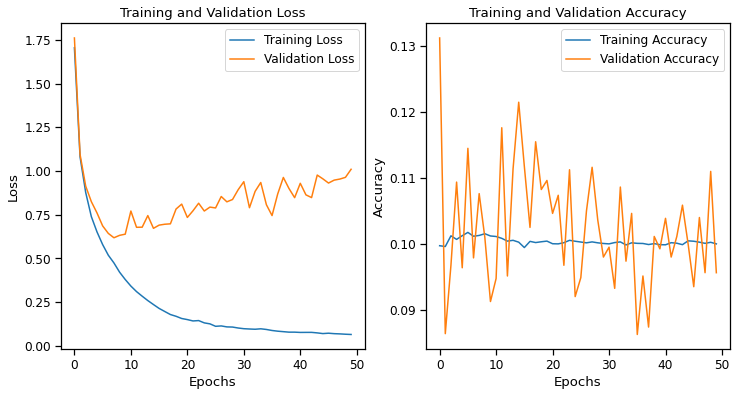

In [45]:
plotLossAccGraph(history5_augment)

In [74]:
# Evaluating performance on train dataset
loss, acc = model4_augment.evaluate(X_train, y_train)
print('  - Train data: loss %.3f - acc %.3f' % (loss, acc))

1563/1563 [==============================] - 6s 4ms/step - loss: 0.7405 - accuracy: 0.0942
  - Train data: loss 0.741 - acc 0.094


In [75]:
# Evaluating performance on cross-validation dataset
loss, acc = model4_augment.evaluate(X_val, y_val)
print('  - Cross-val data: loss %.3f - acc %.3f' % (loss, acc))

250/250 [==============================] - 1s 4ms/step - loss: 0.8347 - accuracy: 0.0913
  - Cross-val data: loss 0.835 - acc 0.091


In [76]:
# Evaluating performance on test dataset
loss, acc = model4_augment.evaluate(X_test, y_test)
print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

63/63 [==============================] - 0s 4ms/step - loss: 0.8073 - accuracy: 0.0975
  - Test data: loss 0.807 - acc 0.097


### Observations and conclusions from fourth model with augmentation
The model achieves:     
* Training accuracy - 9.4%
* Cross-validation accuracy - 9.1%
* Test accuracy - 9.8%

<br>

| Model | Training acc | Cross-val acc | Test acc |
| :----: | :----: | :----:| :----: |
| Baseline model | 63.7% | 59.6% | 61.9% |
| Dropout | 93.3% | 80.3% | 81.8% |
| L2 regularization & Dropout | 98.6% | 83.1% | 83.3% |
| L2 regularization & Increasing Dropout | 99.3% | 87.4% | 88% |
| L2 regularization & Increasing Dropout with augmentation | 9.4% | 9.1% | 9.8% |

<br>

After applying increasing ```image augmentation```, the model performed very poorly and the test accuracy fell to 9.8%.  
Hence, model 4 still performed the best out of all the other models.